In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sys import float_info # Threshold smallest positive floating value


priors = np.array([0.65, 0.35])
weights = np.array([.5, .5])
class0_mean = np.array([[3,0],[0,3]])
class0_cov = np.array([[[2,0],[0,1]],[[1,0],[0,2]]])
class1_mean = np.array([2,2])
class1_cov = np.array([[1,0],[0,1]])

In [80]:
def generateData(numsamples):
    labels = np.where(np.random.rand(numsamples) >= .65, 1, 0)    
    data = np.empty((numsamples,2))

    for i in range(numsamples):
        if(labels[i] == 1):
            data[i] = np.random.multivariate_normal(class1_mean, class1_cov)
        else:
            rand = np.random.rand()
            subclass = 1 if rand>weights[0] else 0
            data[i] = np.random.multivariate_normal(class0_mean[subclass], class0_cov[subclass])
           
    return data, labels

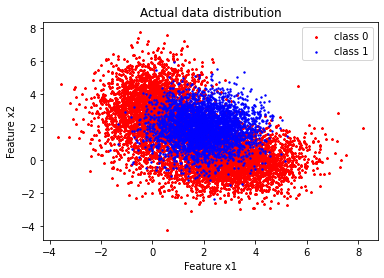

In [81]:
# Generate Training and Validation Datasets
train_data_20, train_labels_20 = generateData(20)
train_data_200, train_labels_200 = generateData(200)
train_data_2000, train_labels_2000 = generateData(2000)
validate_data_10000, validate_labels_10000 = generateData(10000)

train_data = np.array([train_data_20,train_data_200,train_data_2000,],dtype=object)
train_labels = np.array([train_labels_20,train_labels_200,train_labels_2000],dtype=object)

# Plot Raw Data
X = validate_data_10000
labels = validate_labels_10000
samples = 10000

plt.scatter(X[labels==0,0],X[labels==0,1],s=5, color = 'red', label = 'class 0',marker='*')
plt.scatter(X[labels==1,0],X[labels==1,1],s=2, color = 'blue', label = 'class 1',marker='o')
plt.title("Actual data distribution")
plt.xlabel("Feature x1")
plt.ylabel("Feature x2")
plt.legend()


In [82]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(label == 0), sum(label == 1))) #~[6500,3500]

    sorted_score = sorted(discriminant_score)

    # Use tau values that will account for every possible classification split
    # These are all the possible values of Gamma that we will test through
    taus = ([sorted_score[0] - float_info.epsilon] + sorted_score +
             [sorted_score[-1] + float_info.epsilon])
        
    # Calculate the decision label for each observation for each gamma [10000]
    decisions = [discriminant_score >= t for t in taus]

    # True Positive
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]
    # False Positive
    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    
    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = np.array((p10, p11))

    # Calculate error probability
    prob_error = [(p10[w] *priors[0] + (1 - p11[w])* priors[1]) for w in range(len(p10))]

    return roc, taus, prob_error

In [83]:
# Theoretically Optimal Classifier
# Use the 10K validation dataset to find minimum P(error)
x = validate_data_10000
labels = validate_labels_10000
Nlabels = np.array((sum(labels == 0), sum(labels == 1)))

# Class conditional likelihood is a 2x10,000 matrix of likelihoods for each sample based on gaussian distribution
ccl0 = weights[0]*multivariate_normal.pdf(x, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(x, class0_mean[1], class0_cov[1])
ccl1 = multivariate_normal.pdf(x, class1_mean, class1_cov)
class_conditional_likelihoods = np.array([ccl0, ccl1])

# Discriminant Score using log-likelihood ratio: is a 10,000-length vector of values to compare to the threshold
discriminant_score = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Vary Gamma gradually and compute True-Positive and False-Positive probabilities
roc_erm, tau, prob_error = estimate_roc(discriminant_score, labels)

# Find minimum error and index
minimum_error = min(prob_error)
minimum_index = prob_error.index(minimum_error)

# Experimental / approximate Threshold Gamma value
# e^ (undo log in prev cell)
gamma_approx = np.exp(tau[minimum_index])
print("Approximated Gamma = ", gamma_approx)
print("Approximated Minimum Error = ", minimum_error)

gamma_th = priors[0]/priors[1]
# Same as: gamma_th = priors[0]/priors[1]
print("Theoretical Gamma = ", gamma_th)

# get decision for EACH sample based on theoretically optimal threshold
decisions_map = discriminant_score >= np.log(gamma_th)

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nlabels[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nlabels[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nlabels[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nlabels[1]

roc_map = np.array((p_10_map, p_11_map))

# Probability of error for MAP classifier, empirically estimated
prob_error_th = (p_10_map *priors[0] + (1 - p_11_map)* priors[1])
print("Theoretical Minimum Error = ", prob_error_th)

Approximated Gamma =  1.9234712847278286
Approximated Minimum Error =  0.1799699063092979
Theoretical Gamma =  1.8571428571428574
Theoretical Minimum Error =  0.18124209361163823


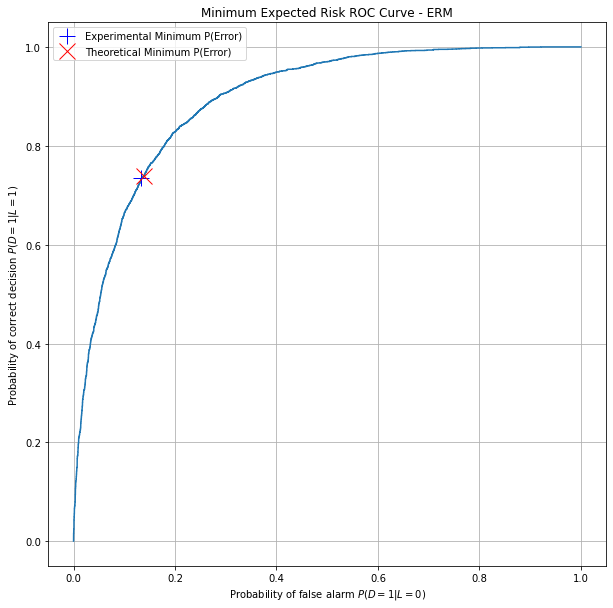

In [84]:
# Plot ROC
fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
ax_roc.plot(roc_erm[0], roc_erm[1])
ax_roc.plot(roc_erm[0,minimum_index], roc_erm[1,minimum_index],'b+', label="Experimental Minimum P(Error)", markersize=16)
ax_roc.plot(roc_map[0], roc_map[1], 'rx', label="Theoretical Minimum P(Error)", markersize=16)
ax_roc.legend()
ax_roc.set_xlabel(r"Probability of false alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $P(D=1|L=1)$")
plt.title("Minimum Expected Risk ROC Curve - ERM")
plt.grid(True)

fig_roc;

(2, 10000)


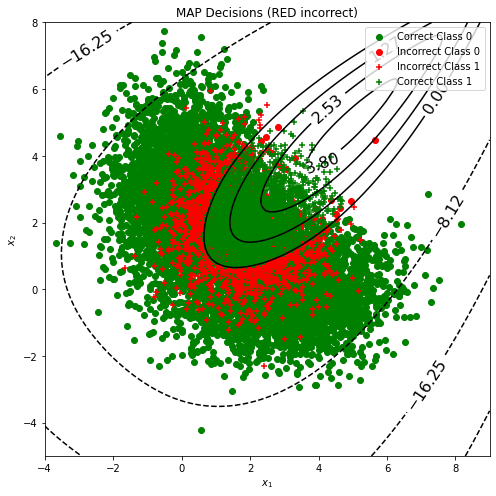

In [85]:
# Generate Ideal Contour Plot
X = validate_data_10000
labels = validate_labels_10000
samples = 10000

fig_disc_grid, ax_disc = plt.subplots(figsize=(7, 7));
ax_disc.scatter(x[ind_00_map, 0], x[ind_00_map, 1], c='g',marker='o', label="Correct Class 0")
ax_disc.scatter(x[ind_10_map, 0], x[ind_10_map, 1],c='r',marker='o', label="Incorrect Class 0")
ax_disc.scatter(x[ind_01_map, 0], x[ind_01_map, 1], c='r',marker='+', label="Incorrect Class 1")
ax_disc.scatter(x[ind_11_map, 0], x[ind_11_map, 1], c='g',marker='+', label="Correct Class 1")

ax_disc.legend();
ax_disc.set_xlabel(r"$x_1$");
ax_disc.set_ylabel(r"$x_2$");
ax_disc.set_title("MAP Decisions (RED incorrect)");
fig_disc_grid.tight_layout();

# Plot IDEAL contours
horizontal_grid = np.linspace(np.floor(np.min(X[:,0])), np.ceil(np.max(X[:,0])), 100)
vertical_grid = np.linspace(np.floor(np.min(X[:,1])), np.ceil(np.max(X[:,1])), 100)

# Generate a grid of scores that spans the full range of data 
[h, v] = np.meshgrid(horizontal_grid, vertical_grid)
# Flattening to feed vectorized matrix in pdf evaluation
gridxy = np.array([h.reshape(-1), v.reshape(-1)])

ccl0 = weights[0]*multivariate_normal.pdf(gridxy.T, class0_mean[0], class0_cov[0]) + weights[1]*multivariate_normal.pdf(gridxy.T, class0_mean[1], class0_cov[1])
ccl1 = multivariate_normal.pdf(gridxy.T, class1_mean, class1_cov)
likelihood_grid_vals = np.array([ccl0, ccl1])

# Where a score of 0 indicates decision boundary level
print(likelihood_grid_vals.shape)
gamma_map = priors[0]/priors[1]
discriminant_score_grid_vals = np.log(likelihood_grid_vals[1]) - np.log(likelihood_grid_vals[0]) - np.log(gamma_map)

# Contour plot of decision boundaries
discriminant_score_grid_vals = np.array(discriminant_score_grid_vals).reshape(100, 100)
equal_levels = np.array((0.3, 0.6, 0.9))
min_DSGV = np.min(discriminant_score_grid_vals) * equal_levels[::-1]
max_DSGV = np.max(discriminant_score_grid_vals) * equal_levels
contour_levels = min_DSGV.tolist() + [0] + max_DSGV.tolist()
cs = ax_disc.contour(horizontal_grid, vertical_grid, discriminant_score_grid_vals.tolist(), contour_levels, colors='k')
ax_disc.clabel(cs, fontsize=16, inline=1)

#plt.show()
fig_disc_grid;

In [86]:
# Gradient Descent Function
def gradient_descent(loss_func, grad_func, theta0, x_tilde, labels, **kwargs):
                     
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6
    
    w = theta0
    w_history = w
    f_history = loss_func(w, x_tilde, labels)
    delta_w = np.zeros(w.shape)
    i = 0
    diff = 1.0e10
    
    while  i<max_epoch and diff>epsilon:
        delta_w = -alpha*grad_func(w, x_tilde, labels)
        w = w+delta_w
        
        # store the history of w and f
        w_history = np.vstack((w_history,w))
        f_history = np.vstack((f_history,loss_func(w, x_tilde, labels)))
        
        # update iteration number and diff between successive values
        # of objective function
        i+=1
        diff = np.absolute(f_history[-1]-f_history[-2])
    
    return w_history,f_history

In [87]:
# Utility Functions
def error_function_gradient(theta, x_tilde, labels):
    a = theta.dot(x_tilde)
    return np.sum(np.multiply(sigmoid(a)-labels, x_tilde), axis = 1)

def error_function(theta, x_tilde, labels):
    a = theta.dot(x_tilde)
    return -np.sum((np.multiply(labels, np.log(sigmoid(a)))+np.multiply((1-labels), np.log(1-sigmoid(a)))), axis=0)

def sigmoid(x):
    return 1/(1+np.exp(-x))

def classify_logistic_linear(x, w):
    x_tilde = np.vstack((np.ones(x.shape[0]), x[:,0], x[:,1]))
    return np.where(sigmoid(w.dot(x_tilde))> .5, 1, 0)
    
def classify_logistic_quadratic(x, w):
    x_tilde = np.vstack((np.ones(x.shape[0]), x[:,0], x[:,1], x[:,0]**2, x[:,0]*x[:,1], x[:,1]**2))
    return np.where(sigmoid(w.dot(x_tilde))> .5, 1, 0)

In [88]:
def plot_boundary(x,labels,decisions,w,priors,samples,quadratic=False):
    Nlabels = np.array((sum(labels == 0), sum(labels == 1)))
    # True Negative Probability
    ind_00 = np.argwhere((decisions==0) & (labels==0))
    p_00 = len(ind_00) / Nlabels[0]
    # False Positive Probability
    ind_10 = np.argwhere((decisions==1) & (labels==0))
    p_10 = len(ind_10) / Nlabels[0]
    # False Negative Probability
    ind_01 = np.argwhere((decisions==0) & (labels==1))
    p_01 = len(ind_01) / Nlabels[1]
    # True Positive Probability
    ind_11 = np.argwhere((decisions==1) & (labels==1))
    p_11 = len(ind_11) / Nlabels[1]

    # Probability of error for MAP classifier, empirically estimated
    prob_error_approx = (p_10 *priors[0] + (1 - p_11)* priors[1])
    print("Approximated Minimum Error = ", prob_error_approx)

    
    fig_disc_grid, ax_disc = plt.subplots(figsize=(7, 7));
    ax_disc.scatter(x[ind_00, 0], x[ind_00, 1], c='g',marker='o', label="Correct Class 0")
    ax_disc.scatter(x[ind_10, 0], x[ind_10, 1],c='r',marker='o', label="Incorrect Class 0")
    ax_disc.scatter(x[ind_01, 0], x[ind_01, 1], c='r',marker='+', label="Incorrect Class 1")
    ax_disc.scatter(x[ind_11, 0], x[ind_11, 1], c='g',marker='+', label="Correct Class 1")


    horizontalGrid = np.linspace(np.floor(min(x[:,0])),np.ceil(max(x[:,0])),100);
    verticalGrid = np.linspace(np.floor(min(x[:,1])),np.ceil(max(x[:,1])),100);

    dsg = np.zeros((100,100))
    a = np.array(np.meshgrid(horizontalGrid,verticalGrid))
    for i in range(100):
        for j in range(100):
            x1 = a[0][i][j]
            x2 = a[1][i][j]
            if quadratic==False:
                z = np.c_[1,x1,x2].T
            else:
                z = np.c_[1,x1,x2,x1**2,x1*x2,x2**2].T
            dsg[i][j] = np.sum(np.dot(w.T,z))
    ax_disc.contour(a[0],a[1],dsg, levels = [0])
    plt.legend()
    plt.title("Decision Boundary trained on {} samples".format(samples))
    plt.xlabel("Feature x1")
    plt.ylabel("Feature x2")
    plt.show()


Approximated Minimum Error =  0.25


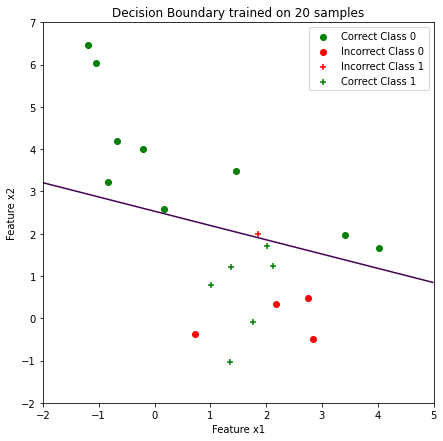

Approximated Minimum Error =  0.6208227091239722


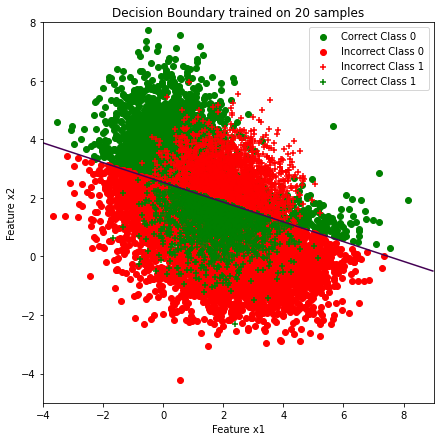

Approximated Minimum Error =  0.4125238469307597


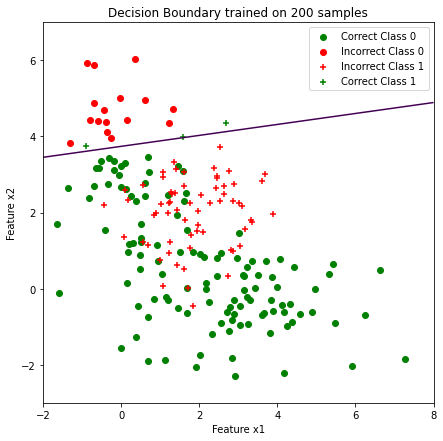

Approximated Minimum Error =  0.43462380415876023


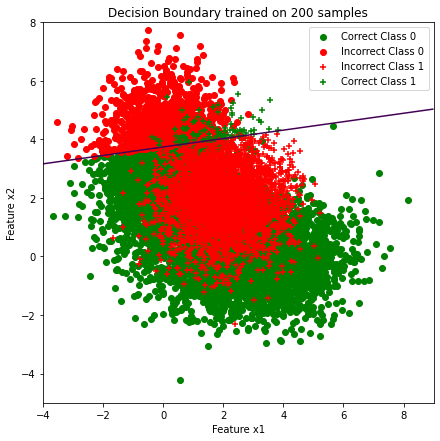

Approximated Minimum Error =  0.3534555421438962


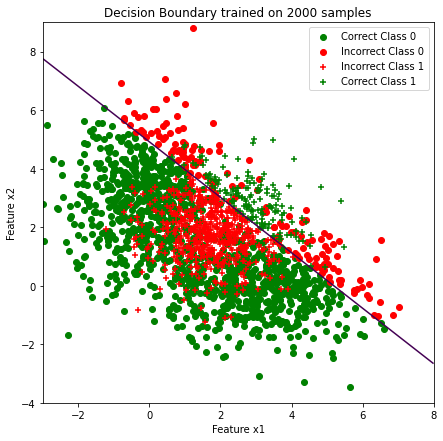

Approximated Minimum Error =  0.34353899826059453


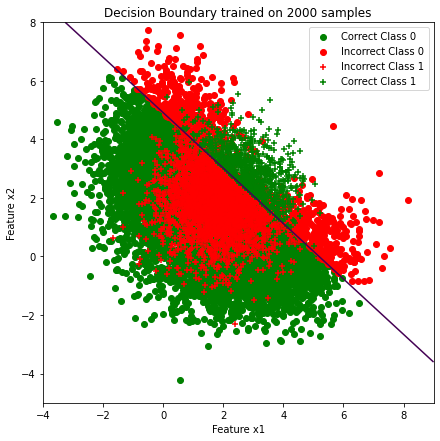

In [89]:
# Linear

# Options for batch GD
opts = {}
opts['max_epoch'] = 10000
opts['alpha'] = 0.0001
opts['tolerance'] = 0.01

theta_init = np.array([1, 0, 0]) # Intialize parameters
gd_max_iter = 10000
gd_threshold = 0.01

for i in range(3):
    x = train_data[i]
    labels = train_labels[i]
    x_tilde = np.vstack((np.ones(x.shape[0]), x[:,0], x[:,1])) # Create augmented X vector
    w_history, f_history = gradient_descent(error_function, error_function_gradient,theta_init, x_tilde, labels, **opts)
    w_estimate = w_history[-1,:]
    decisions_train = classify_logistic_linear(x, w_estimate)

    plot_boundary(x,labels,decisions_train,w_estimate,priors,x.shape[0])

    decisions_validate = classify_logistic_linear(validate_data_10000, w_estimate)
    plot_boundary(validate_data_10000,validate_labels_10000,decisions_validate,w_estimate,priors,x.shape[0])

# x = validate_data_10000
# labels = validate_labels_10000
# x_tilde = np.vstack((np.ones(x.shape[0]), x[:,0], x[:,1])) # Create augmented X vector
# w_history, f_history = gradient_descent(error_function, error_function_gradient,theta_init, x_tilde, labels, **opts)
# w_estimate = w_history[-1,:]
# decisions_train = classify_logistic_linear(x, w_estimate)

# plot_boundary(x,labels,decisions_train,w_estimate,priors,x.shape[0])

    
    

Approximated Minimum Error =  0.2


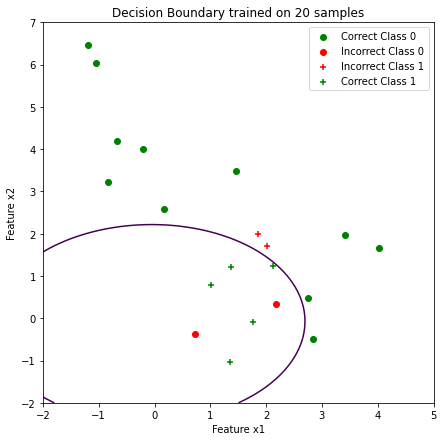

Approximated Minimum Error =  0.4531595904490828


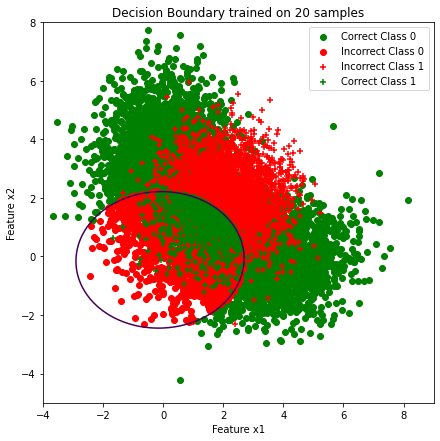

Approximated Minimum Error =  0.18908091123330714


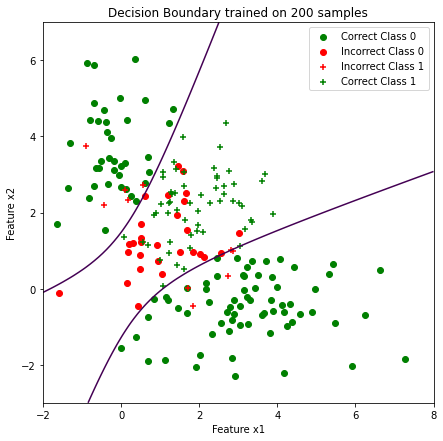

Approximated Minimum Error =  0.2179205704459203


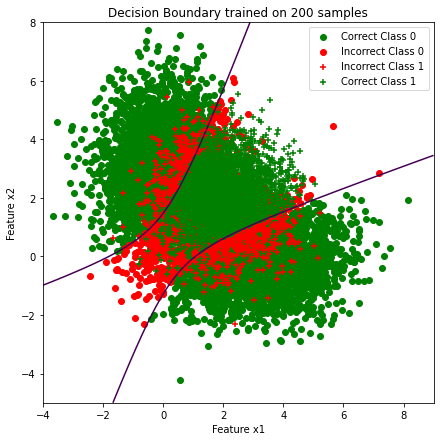

Approximated Minimum Error =  0.16289044708203093


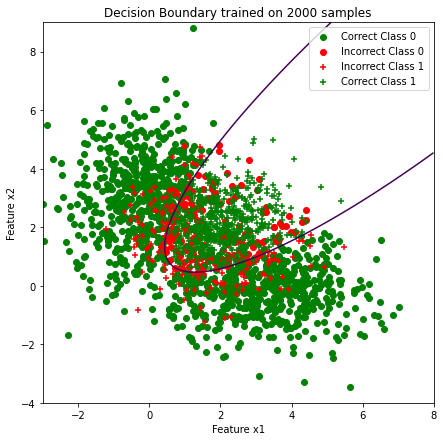

Approximated Minimum Error =  0.18621224699557243


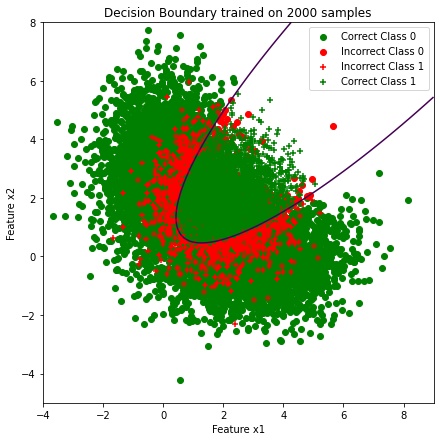

In [90]:
# Quadratic
# Options for batch GD
opts = {}
opts['max_epoch'] = 10000
opts['alpha'] = 0.0001
opts['tolerance'] = 0.01

theta_init = np.array([1, 0, 0, 0, 0, 0]) # Intialize parameters
gd_max_iter = 10000
gd_threshold = 0.01

for i in range(3):
    x = train_data[i]
    labels = train_labels[i]
    x_tilde = np.vstack((np.ones(x.shape[0]), x[:,0], x[:,1], x[:,0]**2, x[:,0]*x[:,1], x[:,1]**2)) # Create augmented X vector
    w_history, f_history = gradient_descent(error_function, error_function_gradient,theta_init, x_tilde, train_labels[i], **opts)
    w_estimate = w_history[-1,:]
    decisions_train = classify_logistic_quadratic(x, w_estimate)

    plot_boundary(x,labels,decisions_train,w_estimate,priors,x.shape[0],quadratic=True)

    decisions_validate = classify_logistic_quadratic(validate_data_10000, w_estimate)
    plot_boundary(validate_data_10000,validate_labels_10000,decisions_validate,w_estimate,priors,x.shape[0],quadratic=True)
